In [1]:
import pandas as pd
SEED=2020
pd.set_option('display.max_columns', 100)
streamers = pd.read_csv("Streamers.csv")
streamers.sample()

,streamerId,install_date,registration_date,gender,streamer_type,followers,coins_earned_all_time,avg_stream_duration,avg_watchers_per_stream,avg_earned_coins_per_stream
940,63391e8494c9c82f2a4a070a,2022-10-02,2022-10-02,male,Individual,NaN,0.0,2.0,3.0,0.0


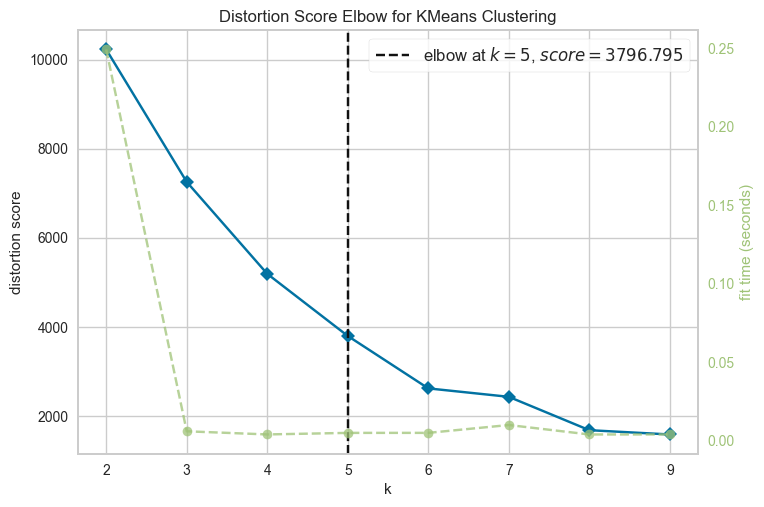

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

# 1. Заміна пропусків на 0 для числових ознак
numeric_features = ['followers', 'coins_earned_all_time', 'avg_stream_duration', 
                    'avg_watchers_per_stream', 'avg_earned_coins_per_stream']
streamers[numeric_features] = streamers[numeric_features].fillna(0)

# 2. Закодування категоріальних ознак у 1/0
categorical_features = ['gender', 'streamer_type']
streamers_data = pd.get_dummies(streamers, columns=categorical_features)

# 3. Перетворення булевих ознак (True/False) у 1/0 після One-Hot Encoding
streamers_data = streamers_data.astype({col: int for col in streamers_data.select_dtypes(include='bool').columns})

# 4. Масштабування даних (виключаємо 'streamerId', 'install_date', 'registration_date', оскільки вони не є корисними для кластеризації)
features = ['followers', 'coins_earned_all_time', 'avg_stream_duration', 
            'avg_watchers_per_stream', 'avg_earned_coins_per_stream', 
            'gender_male','gender_female', 'gender_iPreferNotToSay','streamer_type_Individual', 'streamer_type_Official']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(streamers_data[features])

# 5. Визначення оптимальної кількості кластерів за допомогою KElbowVisualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 10))

#Візуалізація оптимальної кількості кластерів
visualizer.fit(scaled_features)
visualizer.show()

plt.show()


In [3]:
# 6. Кластеризація з обраною кількістю кластерів
optimal_clusters = 5  # на основі методу ліктя
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=SEED)
streamers_data['cluster'] = kmeans.fit_predict(scaled_features)

# Виведення перших кількох рядків з кластерами
print(streamers_data[['streamerId', 'cluster']].head())


                 streamerId  cluster
0  62e317f9a51fb840278916c3        2
1  6334d09b38c52fb3346e72c3        3
2  6308c0f4ab766d90dff98a34        1
3  6338952f08aa4f2581aca7fc        0
4  633785e808aa4f2581ac5cf8        2


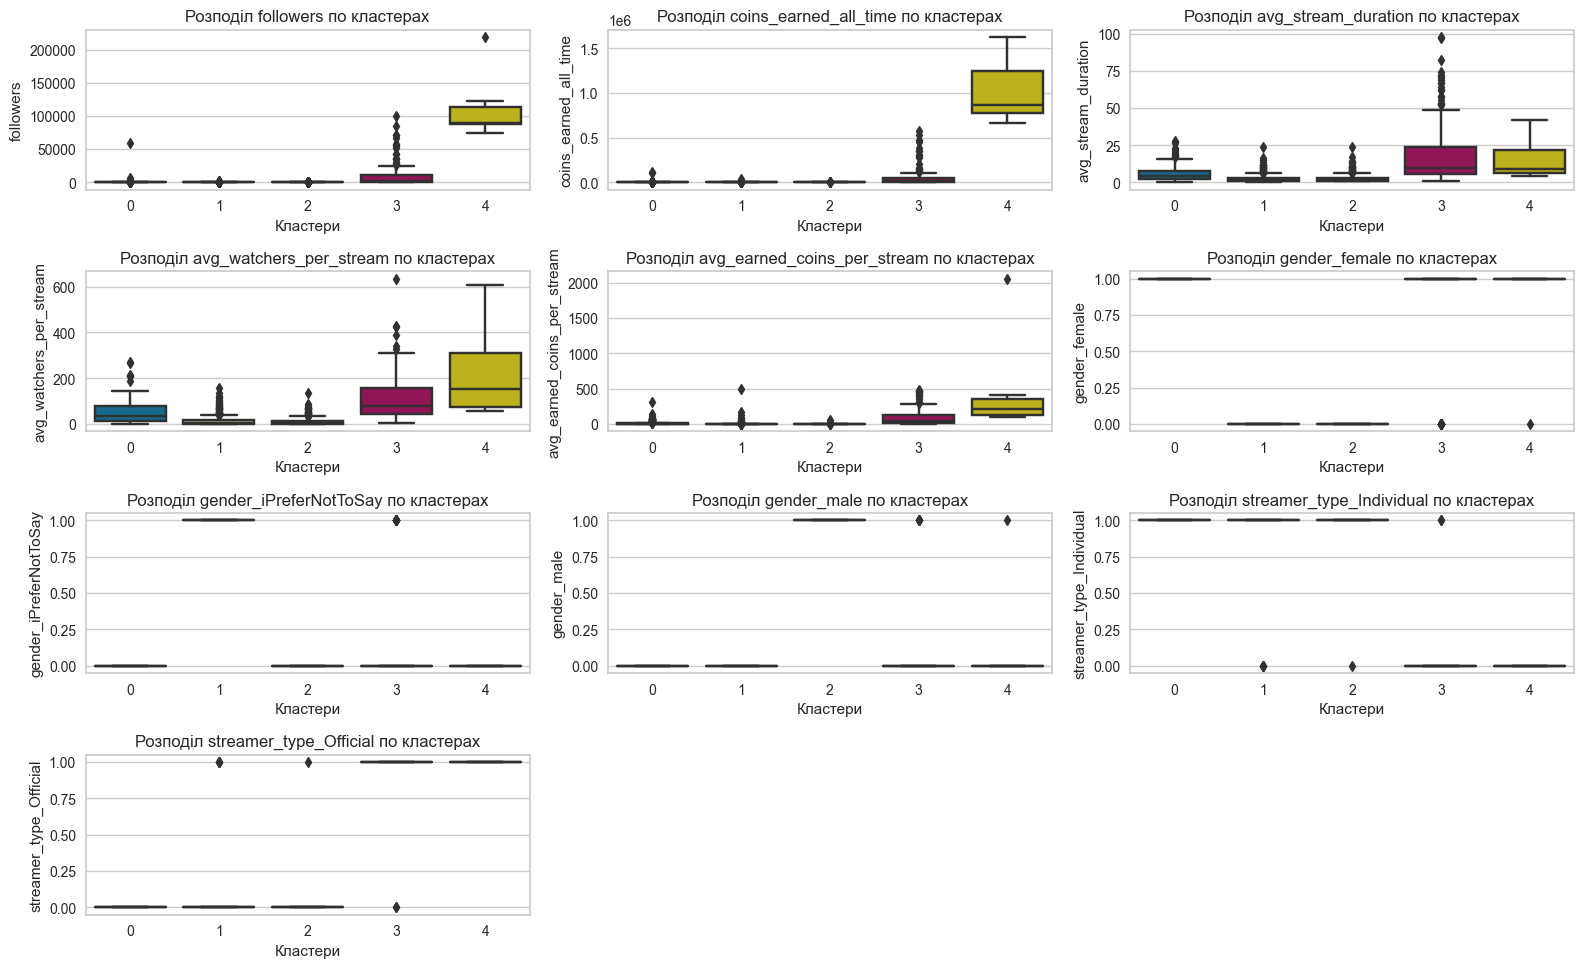

In [5]:
import seaborn as sns

# Список ознак для візуалізації (без дат та ID)
features = ['followers', 'coins_earned_all_time', 'avg_stream_duration',
            'avg_watchers_per_stream', 'avg_earned_coins_per_stream', 
            'gender_female', 'gender_iPreferNotToSay', 'gender_male',
            'streamer_type_Individual', 'streamer_type_Official']

# Визначаємо кількість рядків і стовпців для графіків
n_cols = 3  # Кількість стовпців
n_rows = int(np.ceil(len(features) / n_cols))  # Кількість рядків

# Створюємо фігуру та осі для графіків
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 10))
axes = axes.flatten()  # Перетворюємо осі на одномірний масив для зручності індексації

# Візуалізація кожної ознаки на своїй осі
for i, feature in enumerate(features):
    if streamers_data[feature].dtype != 'object':
        sns.boxplot(x='cluster', y=feature, data=streamers_data, ax=axes[i])
    else:
        # Для категоріальних ознак після one-hot encoding будуємо середні значення по кластерах
        cluster_means = streamers_data.groupby('cluster')[feature].mean().reset_index()
        sns.barplot(x='cluster', y=feature, data=cluster_means, ax=axes[i])

    axes[i].set_title(f'Розподіл {feature} по кластерах')
    axes[i].set_xlabel('Кластери')
    axes[i].set_ylabel(feature)

# Вимкнення порожніх осей, якщо є такі
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Аналіз кластерів за ключовими ознаками

1. **followers**  
   - Стримери з кластера 4 мають найвищу середню кількість підписників (приблизно 100 000), що робить їх найбільш популярною групою.  
   - Кластер 3 також характеризується суттєвим числом підписників, хоча й помітно меншим, ніж у кластера 4. Стримери тут зберігають помітну присутність на платформі.

2. **coins_earned_all_time**  
   - У кластері 4 зосереджені стримери з найвищим загальним заробітком монет (до 1.5 млн), що свідчить про їхню високу комерційну активність.  
   - У кластері 3 також є стримери з відчутними заробітками, але вони суттєво поступаються провідним стримерам кластера 4.

3. **avg_stream_duration**  
   - Кластер 3 вирізняється стримерами з довшими трансляціями — це може бути ознакою іншої моделі роботи з аудиторією.  
   - Для кластера 4 характерні коротші стріми, але це не заважає їм утримувати найбільшу аудиторію та високі заробітки.

4. **avg_watchers_per_stream**  
   - Стримери з кластера 4 мають найбільшу середню кількість глядачів на стрімі, що узгоджується з їхньою популярністю та високою монетизацією.  
   - Кластер 3 демонструє стабільну кількість глядачів, але вона значно менша, ніж у лідерів із кластера 4.

5. **avg_earned_coins_per_stream**  
   - Кластер 4 показує найвищий заробіток за стрім, що підтверджує їхню ефективну взаємодію з аудиторією.  
   - У кластері 3 також спостерігається заробіток за стрім, проте на нижчому рівні.

### Висновки
Кластер 4 можна вважати найбільш успішним за всіма ключовими метриками — від аудиторії до монетизації. Кластер 3 хоч і поступається за показниками, але формує групу активних стрімерів із власною стабільною динамікою.
